In [2]:
%matplotlib inline


# Numerical libraries
import numpy as np

# Import Polynomial Regression library
from sklearn.preprocessing import PolynomialFeatures

# Linear Regression Library
from sklearn.linear_model import LinearRegression

# Cross-Validation related Libraries
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Import Lasso for Dimension Reduction
from sklearn.linear_model import Lasso

# For splitting the dataset into test and Train
from sklearn.model_selection import train_test_split

# For K-Means Clustering
from sklearn.cluster import KMeans

from sklearn.metrics import r2_score
from sklearn import metrics

# to handle data in form of rows and columns
import pandas as pd

# importing ploting libraries
import matplotlib.pyplot as plt

#importing seaborn for statistical plots
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
powerPlant = pd.read_csv('power.csv', header=0 , names = ['Temp','Vacuum','Pressure','Humidity','Power'], encoding='utf-8')

In [4]:
powerPlant.head()

,Temp,Vacuum,Pressure,Humidity,Power
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [5]:
powerPlant.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
Vacuum,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
Pressure,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
Humidity,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
Power,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


# Exploratory Data Analysis

Correlation Graph

<AxesSubplot:>

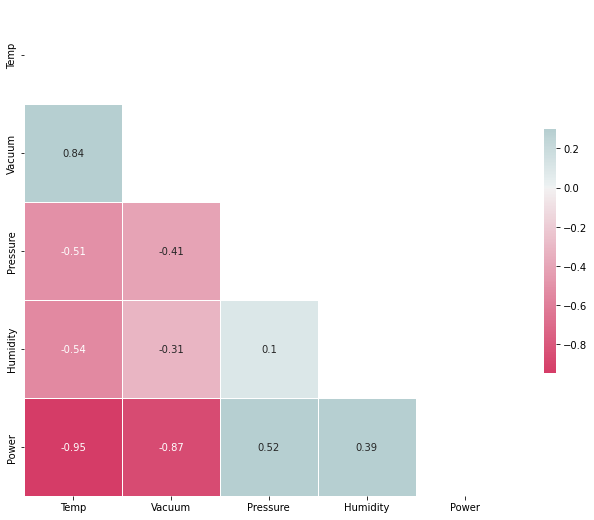

In [6]:
corr = powerPlant.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1,200, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot  = True)

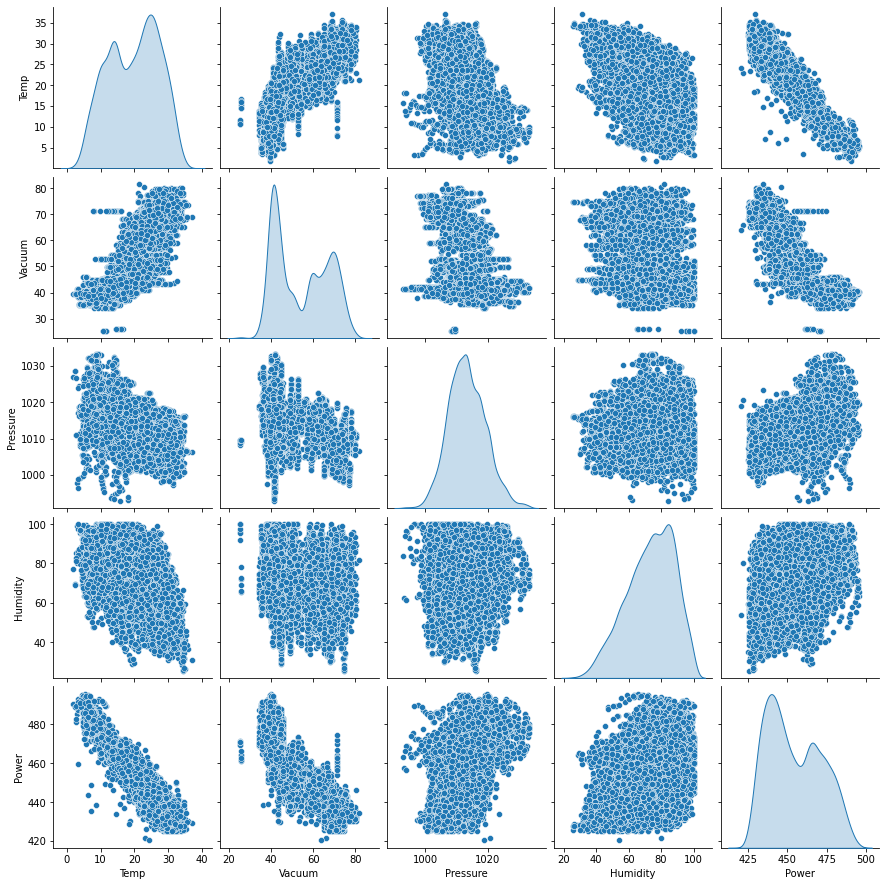

In [7]:


sns.pairplot(powerPlant, diag_kind='kde')

# Clustering

Standardizing the Data before cluster analysis

In [8]:
from scipy.stats import zscore

power = powerPlant.apply(zscore)

In [9]:
power.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp,9568.0,2.918513e-16,1.000052,-2.394126,-0.824096,0.093097,0.814372,2.342804
Vacuum,9568.0,-1.889978e-16,1.000052,-2.277901,-0.988870,-0.175160,0.962775,2.144779
Pressure,9568.0,5.473882e-15,1.000052,-3.430019,-0.700362,-0.053731,0.673729,3.374760
Humidity,9568.0,6.382854e-16,1.000052,-3.270589,-0.683686,0.114115,0.789138,1.839173
Power,9568.0,-1.773386e-15,1.000052,-1.998406,-0.856376,-0.164947,0.824148,2.425568


In [10]:
#### Finding Error for each cluster ####

cluster_range = range( 2, 20)   # expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
    # Use scaled data in the fit() function.
  clusters.fit(power)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

print(clusters_df)

    num_clusters  cluster_errors
0              2    23575.063278
1              3    19286.808310
2              4    16390.103000
3              5    13972.091394
4              6    12541.491826
5              7    11438.340753
6              8    10569.917203
7              9     9930.605076
8             10     9388.475519
9             11     8894.329215
10            12     8438.559353
11            13     8047.683744
12            14     7689.487421
13            15     7400.431271
14            16     7145.972137
15            17     6902.342303
16            18     6701.756564
17            19     6483.044258


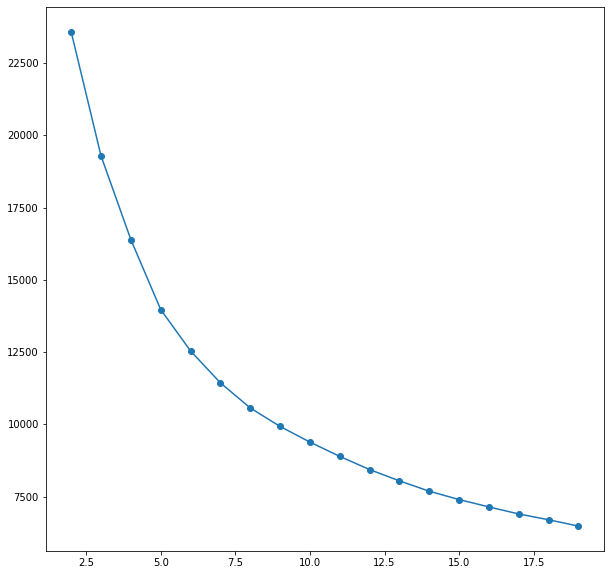

In [11]:
# Elbow plot

plt.figure(figsize=(10,10))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

The knee appears to be at 4 or 5 clusters.

Though the Clustering RSS decreases as the number of clusters are increased. But, for a cluster of 2, the silhouette score is the highest. Hence, we will go forward with two clusters

In [14]:

def ClusterView(n):
    cluster = KMeans( n_clusters = n, random_state = 100 )
    cluster.fit(power)
        # To get the values of Centroid
    centroids = cluster.cluster_centers_
    centroid_df = pd.DataFrame(centroids, columns = list(power) )
    #print(centroid_df)
    prediction=cluster.predict(power)
    power["GROUP"] = prediction
    print(power.head())

        ## Observing the Clusters
    power.boxplot(by = 'GROUP',layout=(4,3) ,figsize=(15, 20))

    #### Modifying Outliers
    data = power   # lazy to type long names. Renaming it to data. Remember data is not a copy of the dataframe

    def replace(group):
        median, std = group.median(), group.std()  #Get the median and the standard deviation of every group
        outliers = (group - median).abs() > 2*std # Subtract median from every member of each group. Take absolute values > 2std
        group[outliers] = group.median()
        return group

    data_corrected = (data.groupby('GROUP').transform(replace))
    concat_data = data_corrected.join(pd.DataFrame(power['GROUP']))

    ## Reviewing the Clusters after removing the outliers
    concat_data.boxplot(by = 'GROUP', layout=(4,3), figsize=(15, 20))

### Viewing the Boxplot for Clusters

       Temp    Vacuum  Pressure  Humidity     Power  GROUP
0 -1.517862 -1.065205 -0.407357  1.143944  1.530226      0
1  0.535255  0.329277 -0.313057  0.061031 -0.504802      1
2  1.353818  0.204151 -1.028729 -2.150688 -0.914386      1
3 -0.077996 -0.363242 -1.016941  0.238434 -0.074710      1
4 -1.053562 -1.073861  0.651838  1.636427  0.589765      0


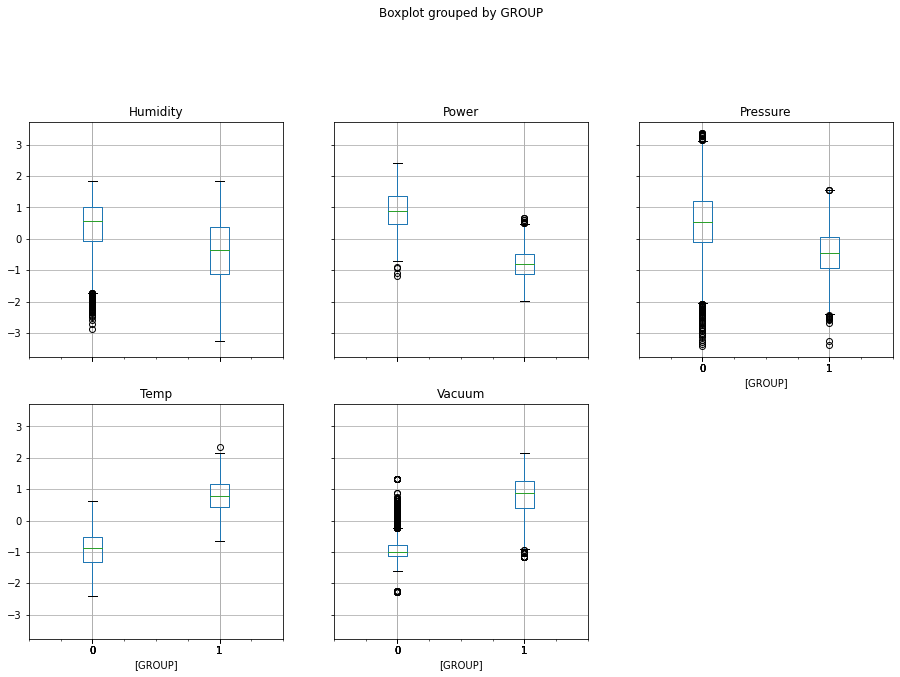

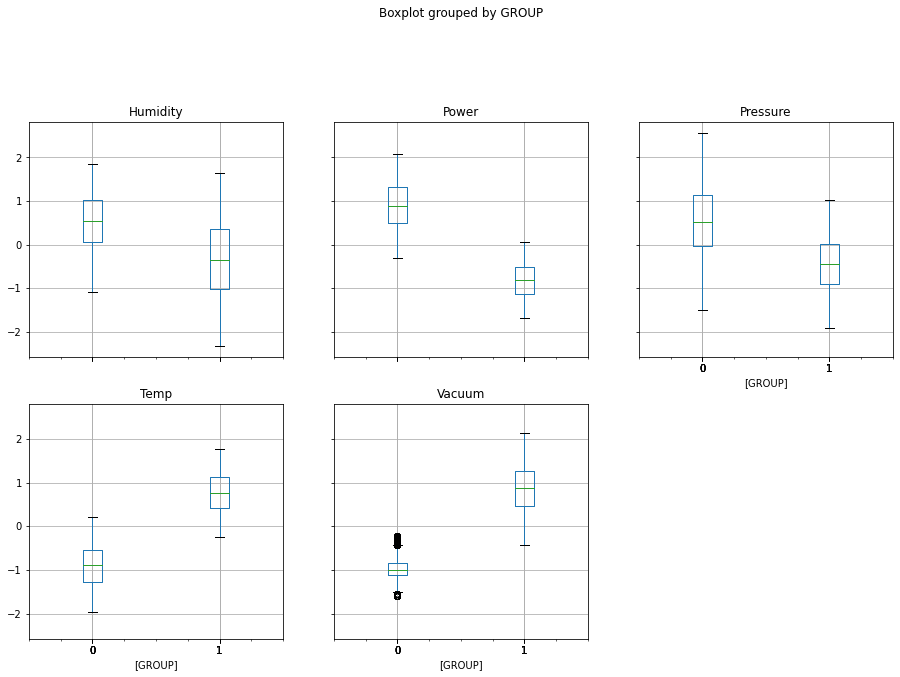

In [15]:
ClusterView(2)

# Modelling

In [16]:
power.head(3)

,Temp,Vacuum,Pressure,Humidity,Power,GROUP
0,-1.517862,-1.065205,-0.407357,1.143944,1.530226,0
1,0.535255,0.329277,-0.313057,0.061031,-0.504802,1
2,1.353818,0.204151,-1.028729,-2.150688,-0.914386,1


In [17]:
power.columns

Index(['Temp', 'Vacuum', 'Pressure', 'Humidity', 'Power', 'GROUP'], dtype='object')

#### Creating Test,Train and Validation dataset

In [18]:
x = power[['Temp', 'Vacuum', 'Pressure', 'Humidity']]
y = powerPlant.Power

In [19]:
y

0       480.48
1       445.75
2       438.76
3       453.09
4       464.43
         ...  
9563    462.59
9564    432.90
9565    465.96
9566    450.93
9567    451.67
Name: Power, Length: 9568, dtype: float64

In [20]:
# intermediate/test split (gives us test set)

x_intermediate, x_test, y_intermediate, y_test = train_test_split(x,y,  test_size = 0.2, random_state =1, shuffle = True)


# train/validation split (gives us train and validation sets)
x_train, x_val, y_train, y_val = train_test_split(x_intermediate, y_intermediate,  test_size = 0.25, random_state =100, shuffle = True)

In [21]:
g=pd.DataFrame({'Temp':1,'Vacuum':2,'Pressure':3,'Humidity':4},index=[0])
print(type(g))
#x_test = np.x_test[x_test,[g]]
#x_test = pd.concat([g, x_test]).reset_index(drop = True)
x_test = pd.concat([g, x_test]).reset_index(drop = True)
x_test.head(5)


<class 'pandas.core.frame.DataFrame'>


,Temp,Vacuum,Pressure,Humidity
0,1.000000,2.000000,3.000000,4.000000
1,-0.248418,-0.833054,-0.766035,0.355561
2,1.335032,1.324773,-0.302953,-1.412307
3,-1.152863,-1.384708,1.416344,0.488443
4,1.396760,1.018648,0.736035,-1.350661


In [22]:
x_test

,Temp,Vacuum,Pressure,Humidity
0,1.000000,2.000000,3.000000,4.000000
1,-0.248418,-0.833054,-0.766035,0.355561
2,1.335032,1.324773,-0.302953,-1.412307
3,-1.152863,-1.384708,1.416344,0.488443
4,1.396760,1.018648,0.736035,-1.350661
...,...,...,...,...
1910,1.159242,1.130396,-1.313314,-0.280076
1911,-0.515457,-0.000457,0.764661,-0.332818
1912,0.625163,0.751871,1.045879,-1.011608
1913,0.548675,0.868340,0.074248,-0.712968


In [23]:
# print proportions
print('train: {}% | Validation: {}% | Test: {}%'.format( round(len(y_train)/len(y),2),
                                                        round(len(y_val)/len(y) ,2),
                                                        round(len(y_test)/len(y),2) ) )

train: 0.6% | Validation: 0.2% | Test: 0.2%


#### Cross-Validation For Polynomial Degree - Using 'cross_val_score' - Useful only if we want to know ONLY about Validation Error

In [24]:
# Various Degrees at which we will test the Polynomial Regression Model
degrees = [1,2,3,4,5,6]
val_error = []
regression_model = LinearRegression()

### Cross Validation for Interaction Only
for degree in degrees:
    poly = PolynomialFeatures( degree = degree, interaction_only= True)
    x_poly = poly.fit_transform(x_intermediate)
    reg = regression_model.fit(x_poly,y_intermediate)
    errors = np.sum( -cross_val_score(reg, x_poly, y_intermediate ,scoring= 'neg_mean_absolute_error', cv=10))

    val_error.append(np.sqrt(errors))

    # RMSE
print(val_error)
print('Lowest Error rate for the degree: {}'.format(degrees[np.argmin(val_error)]))

[6.0287036702917645, 5.827075810535979, 5.775921866278821, 5.77369154405436, 5.77369154405436, 5.77369154405436]
Lowest Error rate for the degree: 4


#### Cross-Validation For Polynomial Degree - Using 'K-Fold' - To see both Train and Validation Error

In [30]:
# Performing a 10-fold cross validation
K = 10

In [31]:
# We need to convert 'x' into array to do the KFold.split
x_array = np.array(x)

In [32]:
########### Defining Functions to calculate Error Metrics ###############

## Returns in-sample error for already fit model
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = metrics.mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
## Returns out-of-sample error for already fit model
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
## fits model and returns the RMSE for in-sample error and out-of-sample error
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [33]:
### Performing the K-fold Cross Validation
kf = KFold(n_splits=K, shuffle = True, random_state=100)
for degree in degrees:
    training_error = []
    validation_error = []
    for train_index, val_index in kf.split(x_array,y):

        # Instantiating Model
        poly = PolynomialFeatures( degree = degree, interaction_only= True)
        x_poly = poly.fit_transform(x_array)
        reg = regression_model.fit(x_poly,y)

        # Split data
        x_train, x_val = x_poly[train_index], x_poly[val_index]
        y_train, y_val = y[train_index], y[val_index]


        # Calculate Error
        train_error, val_error = calc_metrics(x_train, y_train, x_val, y_val, reg)

        # append to appropriate list
        training_error.append(train_error)
        validation_error.append(val_error)
# generate report
    print('Degree: {:6} | mean(train_error): {:7} | mean(val_error): {}'.
          format(degree,
                 round(np.mean(training_error),4),
                 round(np.mean(validation_error),4)))

Degree:      1 | mean(train_error): 20.7661 | mean(val_error): 20.7925
Degree:      2 | mean(train_error): 18.5486 | mean(val_error): 18.599


Degree:      3 | mean(train_error): 18.1962 | mean(val_error): 18.2586
Degree:      4 | mean(train_error): 18.1722 | mean(val_error): 18.2386
Degree:      5 | mean(train_error): 18.1722 | mean(val_error): 18.2386
Degree:      6 | mean(train_error): 18.1722 | mean(val_error): 18.2386


Training error decreases with an increase in degrees due to overfitting! But Validation error shows that a model of degree 4 would give a low error rate.

### LASSO

#### Cross-Validation to find the most optimum alpha using Training and Validation Set

In [34]:
alphas = [0.0001,0.001,0.01,0.1,0.2,0.3,0.5,0.9,0.99]

In [35]:
# Polynomial degree is set to 4.
# Observing for Interaction only.
kf = KFold(n_splits=K, shuffle = True, random_state=100)
for alpha in alphas:
    training_error = []
    validation_error = []
    for train_index, val_index in kf.split(x_array,y):

        # Polynomial Transformation
        poly = PolynomialFeatures( degree = 4, interaction_only= True)
        x_poly = poly.fit_transform(x_array)


        # Split data
        x_train, x_val = x_poly[train_index], x_poly[val_index]
        y_train, y_val = y[train_index], y[val_index]

        #Instantiating Model
        lasso = Lasso(alpha= alpha, fit_intercept=True, random_state=100)

        # Calculate Error
        train_error, val_error = calc_metrics(x_train, y_train, x_val, y_val, lasso)

        # append to appropriate list
        training_error.append(train_error)
        validation_error.append(val_error)
# generate report
    print('Alpha: {:6} | mean(train_error): {:7} | mean(val_error): {}'.
          format(alpha,
                 round(np.mean(training_error),4),
                 round(np.mean(validation_error),4)))

Alpha: 0.0001 | mean(train_error): 18.1722 | mean(val_error): 18.2386
Alpha:  0.001 | mean(train_error): 18.1723 | mean(val_error): 18.2387
Alpha:   0.01 | mean(train_error): 18.1825 | mean(val_error): 18.2466
Alpha:    0.1 | mean(train_error): 18.4463 | mean(val_error): 18.493
Alpha:    0.2 | mean(train_error): 18.8714 | mean(val_error): 18.9154
Alpha:    0.3 | mean(train_error): 19.2634 | mean(val_error): 19.303
Alpha:    0.5 | mean(train_error): 20.2101 | mean(val_error): 20.2477
Alpha:    0.9 | mean(train_error): 23.3696 | mean(val_error): 23.416
Alpha:   0.99 | mean(train_error): 24.1948 | mean(val_error): 24.2416


Since we have the most optimum value of alpha as 0.0001 and a Polynomial of Degree 2. We shall proceed with the model with these set parameters.

In [36]:
poly = PolynomialFeatures( degree = 4, interaction_only= True)
x_poly = poly.fit_transform(x_array)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_poly,y, shuffle = True, test_size = 0.3, random_state =1)

In [39]:
lasso = Lasso(alpha= 0.0001)
lasso.fit(x_train,y_train)

Lasso(alpha=0.0001)

In [40]:
x_test

array([[ 1.        , -0.24841792, -0.83305367, ...,  0.06766222,
         0.22690094, -0.05636626],
       [ 1.        ,  1.3350318 ,  1.3247732 , ...,  0.57121001,
         0.56682074,  0.75672372],
       [ 1.        , -1.15286294, -1.38470817, ..., -0.79755399,
        -0.95794521,  1.10437953],
       ...,
       [ 1.        , -1.53262249, -1.065205  , ...,  0.40906996,
         0.28431226, -0.43574337],
       [ 1.        ,  0.9458789 ,  0.62595837, ...,  0.04113433,
         0.02722164,  0.02574838],
       [ 1.        ,  0.37556862,  0.74478837, ...,  0.08024661,
         0.15913668,  0.05976674]])

In [42]:
# Adjusted R^2

def AdjRsquare(model,x,y):
    Rsquare = model.score(x,y)
    noData = len(y)
    p = x.shape[1]
    tempRsquare = 1 - ((1 - Rsquare)*(noData - 1 ))/(noData - p - 1)
    return tempRsquare

In [43]:
# Model Metrics
print("R^2 for test model:",round(lasso.score(x_test,y_test), 3))
print("Adjusted R^2 for test model:", round(AdjRsquare(lasso, x_test,y_test),3))
print("R^2 for train model:",round(lasso.score(x_train,y_train),3))

print("Adjusted R^2 for train model:", round(AdjRsquare(lasso, x_train,y_train),3))

R^2 for test model: 0.94
Adjusted R^2 for test model: 0.939
R^2 for train model: 0.937
Adjusted R^2 for train model: 0.937


As the Test Metrics are higher than Train Metrics, the Model is 'under-fit'.

# Bootstrapping

In [44]:
from sklearn.utils import resample

In [45]:
power.head(3)

,Temp,Vacuum,Pressure,Humidity,Power,GROUP
0,-1.517862,-1.065205,-0.407357,1.143944,1.530226,0
1,0.535255,0.329277,-0.313057,0.061031,-0.504802,1
2,1.353818,0.204151,-1.028729,-2.150688,-0.914386,1


In [46]:
power.columns

Index(['Temp', 'Vacuum', 'Pressure', 'Humidity', 'Power', 'GROUP'], dtype='object')

In [47]:
# Fetching the Dataframe values in a matrix format
# Dropping the group column as its not needed!!!
values = power[['Temp', 'Vacuum', 'Pressure', 'Humidity', 'Power']].values

Configure Bootstrap Iterations

In [48]:
n_iterations = 100
sample_size = int(len(power)* 0.08)

### Bootstrap Model

In [49]:
stats = list()
for i in range(n_iterations):
    # Train and Test Data
    train = resample(values, n_samples = sample_size) # Sampling with replacement
    test = np.array([x for x in values if x.tolist() not in train.tolist()]) #Out of Box Data
    # Model fitting
    lasso.fit(train[:,:-1], train[:,-1])

    R_score = lasso.score(test[:,:-1], test[:,-1])

    stats.append(R_score)

#### Plotting the Confidence Interval of Test R^2

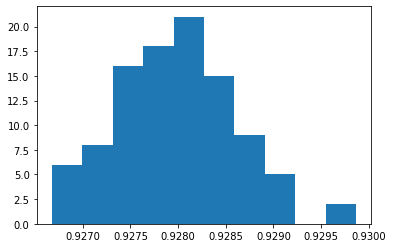

95 percent confidence interval of R^2 : 92.7% and 92.9%


In [50]:
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95                             # for 95% confidence
p = ((1.0-alpha)/2.0) * 100              # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.f percent confidence interval of R^2 : %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

In [51]:
import pickle
pickle.dump(lasso,open('model1.pkl','wb'))
pickle.dump(regression_model,open('model.pkl','wb'))